<a href="https://colab.research.google.com/github/d9249/DACON/blob/main/InceptionResNetV2_2_(public-%2C%20private-).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/test.csv')

In [3]:
!mkdir images_train
!mkdir images_train/0
!mkdir images_train/1
!mkdir images_train/2
!mkdir images_train/3
!mkdir images_train/4
!mkdir images_train/5
!mkdir images_train/6
!mkdir images_train/7
!mkdir images_train/8
!mkdir images_train/9
!mkdir images_test

In [4]:
import cv2

for idx in range(len(train)) :
    img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
    digit = train.loc[idx, 'digit']
    cv2.imwrite(f'./images_train/{digit}/{train["id"][idx]}.png', img)

In [5]:
import cv2

for idx in range(len(test)) :
    img = test.loc[idx, '0':].values.reshape(28, 28).astype(int)
    cv2.imwrite(f'./images_test/{test["id"][idx]}.png', img)

In [6]:
import tensorflow as tf
InceptionResNetV2_model =  tf.keras.applications.InceptionResNetV2(weights=None, include_top=True, input_shape=(224, 224, 1), classes=10)

In [7]:
InceptionResNetV2_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator (
    rescale = 1./255, 
    validation_split = 0.075,
    rotation_range = 15,
    width_shift_range = 0.00,
    height_shift_range = 0.05 )

batch_size = 4
train_generator = datagen.flow_from_directory('./images_train', target_size=(224,224), batch_size = batch_size, color_mode='grayscale', class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory('./images_train', target_size=(224,224), batch_size = batch_size, color_mode='grayscale', class_mode='categorical', subset='validation')

Found 1900 images belonging to 10 classes.
Found 148 images belonging to 10 classes.


In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'/content/drive/MyDrive/DACON_CVLC/Checkpoint/InceptionResNetV2_2.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [10]:
InceptionResNetV2_model.fit_generator(train_generator, epochs=500, validation_data=val_generator, callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
475/475 [==============================] - 99s 143ms/step - loss: 2.0871 - accuracy: 0.2842 - val_loss: 3.8001 - val_accuracy: 0.2162

Epoch 00001: val_accuracy improved from -inf to 0.21622, saving model to /content/drive/MyDrive/DACON_CVLC/Checkpoint/InceptionResNetV2_2.h5
Epoch 2/500
475/475 [==============================] - 68s 144ms/step - loss: 1.5035 - accuracy: 0.4842 - val_loss: 1.9230 - val_accuracy: 0.3851

Epoch 00002: val_accuracy improved from 0.21622 to 0.38514, saving model to /content/drive/MyDrive/DACON_CVLC/Checkpoint/InceptionResNetV2_2.h5
Epoch 3/500
475/475 [==============================] - 70s 147ms/step - loss: 1.1416 - accuracy: 0.6237 - val_loss: 1.2203 - val_accuracy: 0.5878

Epoch 00003: val_accuracy improved from 0.38514 to 0.58784, saving model to /content/drive/MyDrive/DACON_CVLC/Checkpoint/InceptionResNetV2_2.h5
Epoch 4/500
475/475 [==============================] - 70s 147ms/step - loss: 0.9612 - accuracy: 0.6879 - val_loss: 1.8544 - val_a

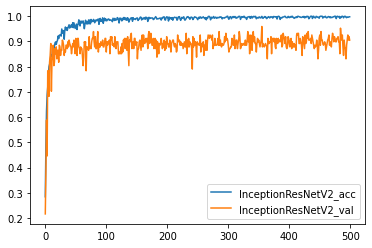

In [11]:
import matplotlib.pyplot as plt

plt.plot(InceptionResNetV2_model.history.history["accuracy"], label='InceptionResNetV2_acc')
plt.plot(InceptionResNetV2_model.history.history["val_accuracy"], label='InceptionResNetV2_val')

plt.legend()
plt.show()

In [12]:
InceptionResNetV2_model = tf.keras.models.load_model('/content/drive/MyDrive/DACON_CVLC/Checkpoint/InceptionResNetV2_2.h5', compile=False)

In [13]:
!mkdir images_test/none
!mv images_test/*.png images_test/none

In [14]:
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory('./images_test', target_size=(224,224), color_mode='grayscale', class_mode='categorical', shuffle=False)

Found 20480 images belonging to 1 classes.


In [15]:
InceptionResNetV2_predict = InceptionResNetV2_model.predict_generator(test_generator).argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [16]:
submission = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/submission.csv')
submission.head()

,id,digit
0,2049,0
1,2050,0
2,2051,0
3,2052,0
4,2053,0


In [17]:
import numpy as np
mylist = []

for i in range(len(submission)):
    name =  test_generator.filenames
    id = name[i].split('/')[1].rstrip('.').split('.')[0]
    mylist.append(id)

In [18]:
for i in range(len(submission)):
    submission["id"][i] = mylist[i]

In [19]:
submission["InceptionResNetV2_predict"] = InceptionResNetV2_predict

In [20]:
from collections import Counter

for i in range(len(submission)) :
    predicts = submission.loc[i, ['InceptionResNetV2_predict']]
    submission.at[i, "digit"] = Counter(predicts).most_common(n=1)[0][0]

In [21]:
submission = submission[['id', 'digit']]

In [22]:
from google.colab import files

submission.to_csv('/content/drive/MyDrive/DACON_CVLC/Submission/InceptionResNetV2_2.csv', index=False)
files.download('/content/drive/MyDrive/DACON_CVLC/Submission/InceptionResNetV2_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>